In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


In [2]:
import sys


import itertools
import numpy as np
import pandas as pd
from scipy import sparse
from scipy import ndimage

import matplotlib.pyplot as plt

import networkx as nx


from src.depth import DepthPoset, ShallowPair
from src import poset_scores

from tqdm import tqdm

# Load Image

/tmp/ipykernel_5240/1918962565.py:3: UserWarning: It is recommended to use mode = grid-constant instead of constant when grid_mode is True.
  image = ndimage.zoom(image, (0.5, 0.5, 1), order=1, grid_mode=True)


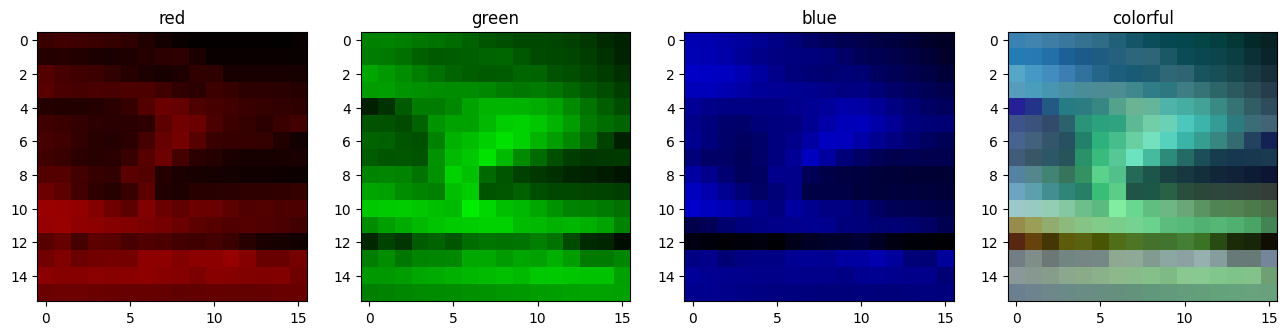

In [3]:
path = 'source/aurora.png'
image = plt.imread(path)[:, :, :3]
image = ndimage.zoom(image, (0.5, 0.5, 1), order=1, grid_mode=True)
#image = ndimage.zoom(image, (0.2, 0.2, 1), order=1, grid_mode=True)



fig, axs = plt.subplots(1, 4, figsize=(16, 5))

for i, color in enumerate(['red', 'green', 'blue']):
    axs[i].set_title(color)
    image_to_show = np.zeros(image.shape)
    image_to_show[:, :, i] = image[:, :, i]
    axs[i].imshow(image_to_show)

#axs[3].set_title('black-white')
#axs[3].imshow(image.mean(axis=2).reshape([image.shape[0], image.shape[1], 1]) * np.ones([1, 1, 3]))

axs[3].set_title('colorful')
axs[3].imshow(image)

plt.show()

# Get border matrix from image

In [4]:
def get_unsorted_order(n, m, with_dims=True):
    """
    """
    # define order
    edges0 = [((x, y), (x+1, y)) for x, y in itertools.product(range(n - 1), range(m))]
    edges1 = [((x, y), (x, y+1)) for x, y in itertools.product(range(n), range(m - 1))]
    squares = list(itertools.product(range(n), range(m)))
    order = squares + edges0 + edges1

    if not with_dims:
        return order

    # define dimensions
    dims = np.concatenate([np.zeros(n*m, dtype=int), np.ones(2*n*m - n - m, dtype=int)])
    assert len(dims) == len(order)

    return order, dims

In [5]:
def get_order_filtrations(img):
    """
    """
    img = np.asarray(img)
    if img.ndim != 2:
        raise ValueError(f'img should be 2-dimensional')
    
    edges0_filtration = np.concatenate(np.max([img[1:, :], img[:-1, :]], axis=0))
    edges1_filtration = np.concatenate(np.max([img[:, 1:], img[:, :-1]], axis=0))
    squares_filtration = np.concatenate(img)

    filtration = np.concatenate([squares_filtration, edges0_filtration, edges1_filtration, ])
    return filtration

In [6]:
def get_sorted_order(img, with_dims=True, with_filtration=True):
    """
    """
    img = np.asarray(img)
    if img.ndim != 2:
        raise ValueError(f'img should be 2-dimensional')
    
    order, dims = get_unsorted_order(img.shape[0], img.shape[1])
    filtration = get_order_filtrations(img)

    indices = np.lexsort((dims, filtration))
    order = [order[i] for i in indices]
    dims = dims[indices]
    filtration = filtration[indices]
    if with_filtration and with_dims:
        return order, dims, filtration
    if with_dims:
        return order, dims
    if with_filtration:
        return order, filtration
    return order

In [7]:
def diagonal_overlay(n, m):
    rows, cols, data = [], [], []

    for i in range(n):
        # Диагональ слева направо (↘)
        if i < m:
            rows.append(i)
            cols.append(i)
            data.append(True)

        # Диагональ справа налево (↘)
        if i < m:
            rows.append(n - i - 1)
            cols.append(m - i - 1)
            data.append(True)

    return sparse.csr_matrix((data, (rows, cols)), shape=(n, m), dtype=bool)


In [8]:

def transpose_minor_diagonal(bm: sparse.csr_matrix) ->sparse. csr_matrix:
    if bm.shape[0] != bm.shape[1]:
        raise ValueError("Matrix must be square to transpose along the minor diagonal.")
    
    n = bm.shape[0]
    bm_coo = bm.tocoo()
    
    # Меняем местами строки и столбцы, с отражением относительно последнего индекса
    new_row = n - 1 - bm_coo.col
    new_col = n - 1 - bm_coo.row
    
    # Создаём новую матрицу
    return sparse.coo_matrix((bm_coo.data, (new_row, new_col)), shape=(n, n)).tocsr()

In [9]:
def get_unsorted_border_matrix(n, m):
    """
    """
    # edges0
    matrix_e0 = diagonal_overlay(n*m - 1, n*m)
    mask = np.array([i % m != (m - 1) for i in range(matrix_e0.shape[0])])
    matrix_e0 = matrix_e0[mask]

    # edges1
    matrix_e1 = diagonal_overlay(m*(n-1), n*m)
    
    # dimension 1-2 submatrix
    bm = sparse.vstack([matrix_e0, matrix_e1])
    
    # geting full matrix
    N = 3*n*m - n - m
    bm = sparse.vstack([bm, sparse.csr_matrix((N - bm.shape[0], bm.shape[1]))])
    bm = sparse.hstack([sparse.csr_matrix((N, N - bm.shape[1])), bm])

    # transpose over minor diagonal
    bm = transpose_minor_diagonal(bm)
    
    return bm.astype(bool)

In [10]:
def get_sorted_border_matrix(img):
    """
    """
    img = np.asarray(img)
    if img.ndim != 2:
        raise ValueError(f'img should be 2-dimensional')
    
    n, m = img.shape
    bm = get_unsorted_border_matrix(n, m)

    order, dims = get_unsorted_order(img.shape[0], img.shape[1])
    filtration = get_order_filtrations(img)
    indices = np.lexsort((dims, filtration))

    bm = bm[indices, :]
    bm = bm[:, indices]
    
    return bm

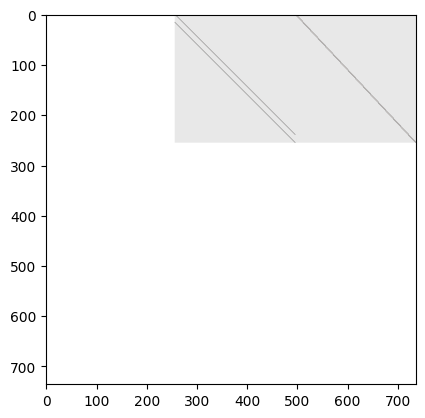

In [11]:
order, dims = get_unsorted_order(image.shape[0], image.shape[1])
bm = get_unsorted_border_matrix(image.shape[0], image.shape[1])

if len(dims) < 4096:
    matrix_dim_condition = dims.reshape((-1, 1)) == dims.reshape((1, -1)) - 1
    plt.imshow(matrix_dim_condition, cmap='Greys', vmin=0, vmax=6)

    bm_to_show = bm.toarray().astype(float)
    bm_to_show[bm_to_show == 0] = np.nan
    plt.imshow(bm_to_show, cmap='Reds')



# Simplifying Class

## Pixels to Disk

Here we are building the map 
$$
    f: D^2\subset \mathbb{R}^2 \to D^2
$$
such that
$$
    f: \delta D^2 \to (\cos\phi, \sin\phi), \phi\in[0, 2\pi)
$$

$n$ ordered points $p_1, ..., p_n \in \delta D^2$:
$$
    f(p_i) = (\cos(i\frac{2\pi}{n}), \sin(i\frac{2\pi}{n}))
$$
and for 1 point $p_c\in D^2/\delta D^2$
$$
    f(p_c) = (0, 0)
$$

We will need this to represent cell as a disk, and calculate height there, based on heights in the $n$ cell vertices

In [12]:

from skimage import measure


def extract_ordered_boundary(mask, return_countor: bool=False):
    """
    Exclude the ordered boundary as list of tuples 

    Parameters:
    -----------
    mask: np.array ndim=2
        The binary mask
    
    return_countor: bool:
        Returns the float coordinates between pixels if True
        Returns the coordinates of the pixesl if False

    Returns:
    --------
    ordered_boundary: list[tuple]
        coordinates of the boundary
    """
    contours = measure.find_contours(mask.astype(float), level=0.5)
    if not contours:
        raise ValueError("Could not find a border")
    
    # Take the longest border if there are many
    contour = max(contours, key=len)
    if return_countor:
        return contour

    # Choose the border pixels
    ordered_boundary = [(int(round(y)), int(round(x))) for y, x in contour]
    ordered_boundary = [(y, x) for y, x in contour]
    ordered_boundary = []
    for y, x, in contour:
        if y%1 == 0:
            y, x = int(y), int(x)
            if not mask[y, x]:
                x += 1
        else:
            y, x = int(y), int(x)
            if not mask[y, x]:
                y += 1
        if (y, x) not in ordered_boundary:
            ordered_boundary.append((y, x))
    

    return ordered_boundary

In [13]:
from src.cplane import get_map_disk_to_unit

/tmp/ipykernel_5240/4026499010.py:12: UserWarning: It is recommended to use mode = grid-constant instead of constant when grid_mode is True.
  mask = ndimage.zoom(mask, (4, 4), order=1, grid_mode=True).astype(bool).astype(int)


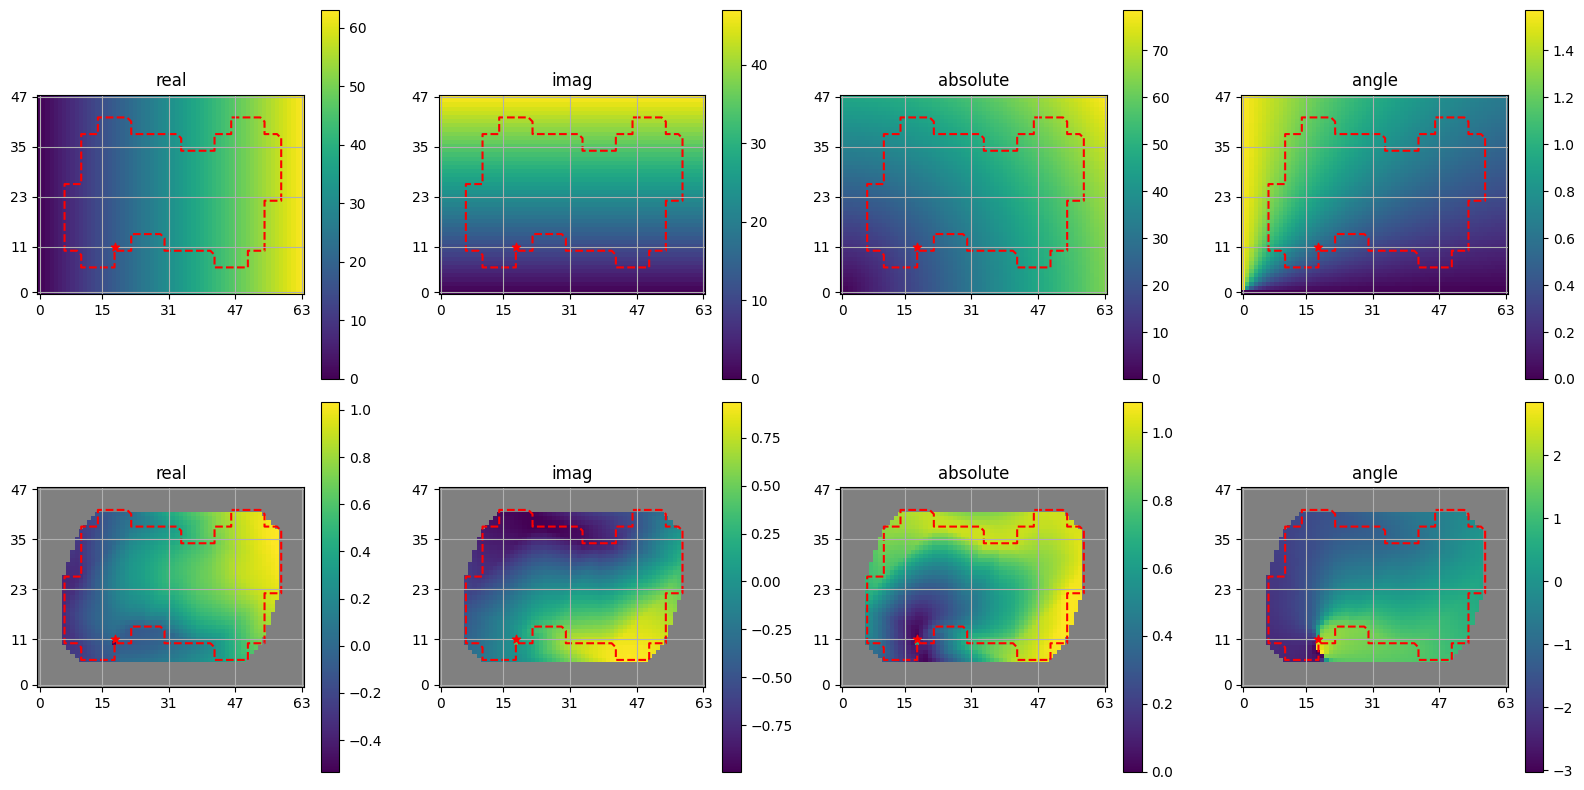

In [14]:
mask = np.zeros([16, 12])
mask[2, 3:6] = 1
mask[3, 2:9] = 1
mask[4, 3:10] = 1
mask[5:8, 8] = 1
mask[5:11, 4:8] = 1
mask[8:11, 3] = 1
mask[11, 2:9] = 1
mask[12, 3:10] = 1
mask[13, 6:9] = 1

mask = ndimage.zoom(mask, (4, 4), order=1, grid_mode=True).astype(bool).astype(int)
#mask = ndimage.zoom(mask, (8, 8), order=1, grid_mode=True).astype(bool).astype(int)

center_x, center_y = np.argwhere(mask)[np.random.randint(mask.sum())]

boundary = extract_ordered_boundary(mask, return_countor=True)
boundary_x, boundary_y = np.transpose(boundary)
boundary_angles = np.arange(len(boundary))/len(boundary) * 2*np.pi

x = np.arange(mask.shape[0])
y = np.arange(mask.shape[1])
z = x.reshape(1, -1) + 1j*y.reshape(-1, 1)

zs = boundary_x + 1j*boundary_y
z_center = center_x + 1j*center_y
    
zx = np.append(zs, zs[0]).real
zy = np.append(zs, zs[0]).imag
zx = np.searchsorted(x, zx)
zy = np.searchsorted(y, zy)

f = get_map_disk_to_unit(z_center, zs)

cmap = plt.get_cmap().copy()
cmap.set_bad(color='gray')

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for (i_col, repr), (i_row, z) in itertools.product(enumerate([np.real, np.imag, np.abs, np.angle]), enumerate([z, f(z)])):
    axs[i_row, i_col].set_title(f'{repr.__name__}')
    img = repr(z)
        
    sm = axs[i_row, i_col].imshow(img, cmap=cmap, origin='lower')
    plt.colorbar(sm, ax=axs[i_row, i_col])

    axs[i_row, i_col].plot(zx, zy, color='red', linestyle='--', zorder=1)
    axs[i_row, i_col].scatter(center_x, center_y, color='red', marker='*', zorder=2)
    axs[i_row, i_col].set_xticks(np.linspace(0, len(x)-1, 5).astype(int), x[np.linspace(0, len(x)-1, 5).astype(int)])
    axs[i_row, i_col].set_yticks(np.linspace(0, len(y)-1, 5).astype(int), y[np.linspace(0, len(y)-1, 5).astype(int)])
    axs[i_row, i_col].grid(True)

plt.tight_layout()
plt.show()

In [15]:
def piecewise_linear_on_circle(phi, angles, angle_values=None):
    """
    Evaluate a piecewise-linear function defined on a circle at given angles.

    Parameters
    ----------
    phi : array_like of float
        Query angles (in radians) at which to evaluate the function. Can be
        a scalar, 1D array, or higher-dimensional array; the output will have
        the same shape.
    angles : array_like of float
        Angles (in radians) of the sample points on the circle. Values may be
        unsorted and outside the range [0, 2π); they are normalized and sorted
        internally. Must contain at least two distinct points.
    angle_values : array_like of float, optional
        Function values corresponding to `angles`. If omitted, all values are 
        assumed to be 0. Must have the same length as `angles` if provided.

    Returns
    -------
    ndarray
        Interpolated function values at the query angles `phi`, with the same 
        shape as `phi`.
    """
    if angle_values is None:
        angle_values = np.zeros(len(angles), dtype=float)
    
    angles = np.array(angles)
    angles %= 2*np.pi
    angle_values = np.array(angle_values)[np.argsort(angles)]
    angles = angles[np.argsort(angles)]
    angles = np.concatenate([[angles[-1] - 2*np.pi], angles, [angles[0] + 2*np.pi]])
    angle_values = np.concatenate([[angle_values[-1]], angle_values, [angle_values[0]]])

    phi = np.array(phi)
    phi_shape = phi.shape
    phi = phi.reshape(-1)
    phi %= 2*np.pi
    phi_index = (phi.reshape(1, -1) >= angles[:-1].reshape(-1, 1)) & (phi.reshape(1, -1) < angles[1:].reshape(-1, 1))
    phi_index = phi_index.argmax(axis=0)
    
    t = (phi - angles[phi_index])/(angles[phi_index + 1] - angles[phi_index])
    res = (1 - t)*angle_values[phi_index] + t*angle_values[phi_index + 1]
    res = res.reshape(phi_shape)
    return res

In [16]:
def conical_piecewise_linear(z, angles, angle_values=None, center_value: float=0):
    """
    Evaluate a conical (radially-linear) extension of piecewise-linear boundary data
    on the unit disk.

    Parameters:
    -----------
    z: compelx or complex array
        Input from the complex unit disk

    angles : array_like of float
        Angles (in radians) of the sample points on the circle. Values may be
        unsorted and outside the range [0, 2π); they are normalized and sorted
        internally. Must contain at least two distinct points.
    angle_values : array_like of float, optional
        Function values corresponding to `angles`. If omitted, all values are 
        assumed to be 0. Must have the same length as `angles` if provided.
    center_value: float
        Function value in the center
    
    Returns
    -------
    ndarray
        Interpolated function values at the query angles `phi`, with the same 
        shape as `phi`.
    """
    phi = np.angle(z)
    r = np.absolute(z)
    return (1 - r)*center_value + r*piecewise_linear_on_circle(phi, angles, angle_values)

## Simplification itself

In [17]:
import networkx as nx
from collections import deque

def nearest_two_non_degree2_nodes(G: nx.Graph, start):
    """Возвращает два кортежа (узел, длина_пути) для ближайших к start вершин с degree != 2."""
    if G.degree[start] != 2:
        raise ValueError(f"Вершина {start} имеет степень {G.degree[start]}, а не 2")

    visited = {start}
    q = deque([(start, 0)])
    result = []

    while q:
        u, d = q.popleft()
        for v in G.neighbors(u):
            if v in visited:
                continue
            visited.add(v)
            nd = d + 1
            if G.degree[v] != 2:
                result.append((v, nd))
                if len(result) == 2:
                    return tuple(result)
            else:
                q.append((v, nd))

    raise ValueError("Не удалось найти две вершины с degree != 2")


In [18]:
class SimplifiedByCancelations:
    def __init__(self, image, cancelations: list[ShallowPair]=[]):
        """
        The topologica simplification of a 2-dimensional black-white image by canceling shallow pairs.
        """
        self.image = np.array(image)
        if self.image.ndim != 2:
            raise ValueError('The image should be 2-dimensional')
        self.shape = self.image.shape
        
        # Geting list of components
        g = nx.Graph()
        g.add_nodes_from(itertools.product(range(image.shape[0]), range(image.shape[1])))
        g.add_edges_from([node.source[1] for node in cancelations])
        self.components = [list(component) for component in nx.connected_components(g)]
        
        # geting the only not canceled pixels in the components
        canceled_pixels = {node.source[0] for node in cancelations}
        self.merge_targets = [set(component) - canceled_pixels for component in self.components]
        assert np.all([len(target) == 1 for target in self.merge_targets])
        self.merge_targets = [next(iter(target)) for target in self.merge_targets]

    def __len__(self):
        """
        Returns the number of components
        """
        return len(self.components)

    def get_segmentation(self, add_frame=False):
        """
        Returns the segmentation based on the cancelations

        Parameters:
        -----------
        add_frame: bool
            Add a frame as an aditional component index len(self)

        Returns:
        --------
        new_image: 2-dimensional integer np.array
        """
        if add_frame:
            segement_matrix = np.ones([self.shape[0] + 2, self.shape[1] + 2])*len(self)
            segement_matrix[1:-1, 1:-1] = self.get_segmentation(add_frame=False)
            return segement_matrix

        segement_matrix = np.zeros(self.shape)*np.nan
        for i, component in enumerate(self.components):
            rows, cols = zip(*component)
            segement_matrix[rows, cols] = i
        return segement_matrix
    
    def represent_flat(self):
        """
        Returns the simplified image, assuming for every component the representative merge target pixel value

        Returns:
        --------
        new_image: 2-dimensional np.array
        """
        new_image = self.image.copy()
        for component, (merge_target_x, merge_target_y) in zip(self.components, self.merge_targets):
            value = self.image[merge_target_x, merge_target_y]
            rows, cols = zip(*component)
            new_image[rows, cols] = value
        return new_image

    def get_component_connectivity_graph(self, add_frame=False):
        """
        Returns the graph, where 
        nodes are component indices
        edges exists if 2 components have a border (4-connectivity)

        Parameters:
        -----------
        add_frame: bool
            Add an aditional component index len(self), representing the frame of the image

        Returns:
        --------
        g: nx.Graph
        """
        segment_matrix = self.get_segmentation(add_frame=add_frame)
        
        edges_v = np.transpose([segment_matrix[1:, :], segment_matrix[:-1, :]], (1, 2, 0))[segment_matrix[1:, :] != segment_matrix[:-1, :]]
        edges_h = np.transpose([segment_matrix[:, 1:], segment_matrix[:, :-1]], (1, 2, 0))[segment_matrix[:, 1:] != segment_matrix[:, :-1]]
        edges = np.concatenate([edges_v, edges_h])
        edges = np.unique(np.sort(edges, axis=1), axis=0)

        g = nx.Graph()
        g.add_nodes_from(np.unique(segment_matrix))
        g.add_edges_from(edges)
        return g
    
    def get_vertices(self, add_frame=False):
        """
        Returns indices of pixel, in which neighbourhood more than 2 segments.

        The neighbourhood of a pixel contains 4 pixel: this pixel itself 

        Parameters:
        -----------
        add_frame: bool
            Do we count frame as a segment
        """
        segment_matrix = self.get_segmentation(add_frame=add_frame)

        slices = np.array([segment_matrix[1:, 1:], 
                           segment_matrix[1:, :-1], 
                           segment_matrix[:-1, 1:], 
                           segment_matrix[:-1, :-1]])
        nsegments = np.apply_along_axis(lambda row: len(np.unique(row)), axis=0, arr=slices)
        vertices = np.argwhere(nsegments >= 3)
        rows, cols = zip(*vertices)
        vertex_segments = slices[:, rows, cols]
        vertex_segments = [tuple(np.unique(vertex_segment)) for vertex_segment in vertex_segments.transpose()]

        if add_frame:
            vertices -= 1
    
    def classify_components(self) -> list[str]:
        """
        Defines the types for each component. 
        There are 3 types are possible:
        - 'min' - local minima
        - 'max' - local maxima
        - 'saddle' - saddle
        """            
        try:
            self.component_types
        except AttributeError:
            connectivity_graph = self.get_component_connectivity_graph(add_frame=False)
            component_types = []
            for i, (i_merge_target_x, i_merge_target_y) in enumerate(self.merge_targets):
                i_value = self.image[i_merge_target_x, i_merge_target_y]
                neighbors = list(connectivity_graph.neighbors(i))
                neighbors = np.array(neighbors, dtype=int)
                neighbors_merge_target_x, neighbors_merge_target_y = np.transpose(np.array(self.merge_targets)[neighbors])
                neighbors_values = self.image[neighbors_merge_target_x, neighbors_merge_target_y]
                if (i_value <= neighbors_values).all():
                    i_type = 'min'
                elif (i_value >= neighbors_values).all():
                    i_type = 'max'
                else:
                    i_type = 'saddle'
                component_types.append(i_type)
            self.component_types = np.array(component_types)
        return self.component_types
    
    def get_boundary_vertices_graph(self, add_frame=True):
        """
        """
        segment_matrix = self.get_segmentation(add_frame=add_frame)
        slices = np.array([segment_matrix[1:, 1:], 
                           segment_matrix[1:, :-1], 
                           segment_matrix[:-1, 1:], 
                           segment_matrix[:-1, :-1]])
        
        nsegments = np.apply_along_axis(lambda row: len(np.unique(row)), axis=0, arr=slices)
        vertices = np.argwhere(nsegments >= 2)
        rows, cols = zip(*vertices)
        vertices_segments = slices[:, rows, cols]
        vertices_segments = [tuple(np.unique(vertex_segment)) for vertex_segment in vertices_segments.transpose()]

        vertices = vertices.astype(float)
        if add_frame:
            vertices -= 0.5
        else:
            vertices += 0.5
            
        nodes = [(i, {'vertex': vertex, 'segments': vertex_segments}) for i, (vertex, vertex_segments) in enumerate(zip(vertices, vertices_segments))]
        g = nx.Graph()
        g.add_nodes_from(nodes)

        H, W = segment_matrix.shape
        edges_pos_h = np.argwhere(segment_matrix[:, 1:] != segment_matrix[:, :-1]) + np.array([0.0, 0.5]) - 1
        edges_pos_v = np.argwhere(segment_matrix[1:, :] != segment_matrix[:-1, :]) + np.array([0.5, 0.0]) - 1
        edges_pos = np.concatenate([edges_pos_h, edges_pos_v])
        def edges_cond(n0, n1):
            v0 = g.nodes[n0]['vertex']
            v1 = g.nodes[n1]['vertex']
            if np.linalg.norm(v0 - v1) != 1:
                return False
            vm = 0.5 * (v0 + v1)

            # border conditions
            if (vm == -0.5).any() or vm[0] == H - 0.5 or vm[1] == W - 0.5:
                return True

            return (edges_pos == vm).all(axis=1).any()

        edges = [(n0, n1) for n0, n1 in itertools.product(g.nodes(), repeat=2) if edges_cond(n0, n1)]
        g.add_edges_from(edges)
        return g
    
    def get_heighted_boundary_vertices_graph(self, add_frame=True):
        """
        """
        segment_filtration_vals = [self.image[merge_target_x, merge_target_y] for merge_target_x, merge_target_y in self.merge_targets]
        segment_filtration_vals = np.append(segment_filtration_vals, +np.inf)

        g = self.get_boundary_vertices_graph(add_frame)
        vertex_nodes = [node for node in g.nodes() if g.degree(node) != 2]
        vertex_vals = [segment_filtration_vals[np.array(g.nodes[node]['segments']).astype(int)].min() for node in vertex_nodes]
        
        for node, val in zip(vertex_nodes, vertex_vals):
            g.nodes[node]['value'] = val
        border_nodes = [node for node in g.nodes() if g.degree(node) == 2]
        for node in border_nodes:
            (n0, p0), (n1, p1) = nearest_two_non_degree2_nodes(g, node)
            val0 = g.nodes[n0]['value']
            val1 = g.nodes[n1]['value']
            t = 1 - p0/(p0 + p1)
            val = t*val0 + (1 - t)*val1
            g.nodes[node]['value'] = val

        return g

    def represent_conical(self):
        """
        """
        self.classify_components()
        g = self.get_heighted_boundary_vertices_graph(add_frame=True)

        new_image = self.image.copy()
        for i, (component, component_type, (merge_target_x, merge_target_y)) in enumerate(zip(self.components, self.component_types, self.merge_targets)):
            component_x, component_y = np.transpose(component)
            if component_type == 'saddle':
                center_x, center_y = merge_target_x, merge_target_y
            if component_type == 'min':
                center_x, center_y = np.array(component)[self.image[component_x, component_y].argmin()]
            if component_type == 'max':
                center_x, center_y = np.array(component)[self.image[component_x, component_y].argmax()]
            center_value = self.image[center_x, center_y]
            z0 = center_x + 1j*center_y
            
            border_g_edges = nx.find_cycle(g.subgraph([node for node in g.nodes() if i in g.nodes[node]['segments']]))
            border_g_nodes = [border_g_edges[0][0]] + [v for _, v in border_g_edges]
            border_g_values = np.array([g.nodes[node]['value'] for node in border_g_nodes])
            border_g_vertices = np.array([g.nodes[node]['vertex'] for node in border_g_nodes])
            zs = border_g_vertices[:, 0] + 1j*border_g_vertices[:, 1]

            angles = 2*np.pi*np.arange(len(zs))/len(zs)
            map_disk_to_unit = get_map_disk_to_unit(z0, zs, angles)
            component_disk = map_disk_to_unit(component_x + 1j*component_y)
            component_value = conical_piecewise_linear(component_disk, angles, angle_values=border_g_values, center_value=center_value)
            new_image[component_x, component_y] = component_value
        return new_image


In [19]:
class DepthSimplifyer:
    def __init__(self, image):
        """
        """
        self.image = np.array(image)
        if self.image.ndim != 2:
            raise ValueError('The image should be 2-dimensional')
        
        order, dims, filtration = get_sorted_order(self.image)
        bm = get_sorted_border_matrix(self.image)
        self.depth_poset = DepthPoset.from_border_matrix(border_matrix=bm.toarray().astype('int8'), dims=dims, 
                                                         filter_values=filtration, sources=order)

    def get_simplified(self, cancelations: list[ShallowPair]=[]) -> SimplifiedByCancelations:
        """
        """
        cancelations_with_descendats = self.depth_poset.get_ancestors(cancelations, include=True).nodes
        return SimplifiedByCancelations(self.image, cancelations_with_descendats)
    
    def get_simplified_by_condition(self, condition=lambda cell: False) -> SimplifiedByCancelations:
        """
        """
        cancelations = self.depth_poset.subposet(node_condition=condition).nodes
        return self.get_simplified(cancelations)

    def get_simplified_by_fixing_height(self, height: int) -> SimplifiedByCancelations:
        """
        """
        pass

    def get_simplified_by_canceling_minimals(self, n_iters: int=1) -> SimplifiedByCancelations:
        """
        """
        dp = self.depth_poset
        minimal_nodes = []
        for i in range(n_iters):
            minimal_nodes += list(dp.iterate_minimal_nodes())
            dp = dp.subposet(node_condition=lambda node: node not in minimal_nodes)
        return self.get_simplified(cancelations=minimal_nodes)

    def get_simplified_by_canceling_short_lifes(self, life_length: float) -> SimplifiedByCancelations:
        """
        """
        condition = lambda node: node.death_value - node.birth_value < life_length
        return self.get_simplified_by_condition(condition=condition)

In [20]:
import matplotlib as mpl

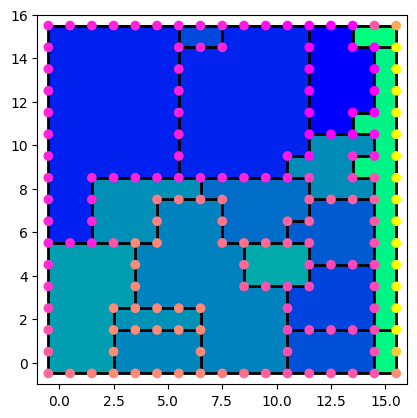

In [21]:
img = image.mean(axis=2)
simplifyer = DepthSimplifyer(img)

simplification = simplifyer.get_simplified_by_canceling_minimals(1)

g = simplification.get_heighted_boundary_vertices_graph()
pos = {node: g.nodes[node]['vertex'] for node in g.nodes()}

min_val = np.min([g.nodes[node]['value'] for node in g.nodes()])
max_val = np.max([g.nodes[node]['value'] for node in g.nodes()])

cmap = plt.get_cmap('spring')
colors = []
for node in g.nodes:
    try:
        val = g.nodes[node]['value']
        val = (val - min_val)/(max_val - min_val)
        color = mpl.colors.to_hex(cmap(val))
        colors.append(color)
    except KeyError:
        colors.append('grey')


plt.imshow(simplification.represent_flat().transpose(), cmap='winter')
nx.draw_networkx(g, pos=pos, with_labels=False, node_size=36, node_color=colors, edge_color='black', width=2, hide_ticks=False)

plt.xlim(-1, img.shape[0])
plt.ylim(-1, img.shape[1])
plt.show()

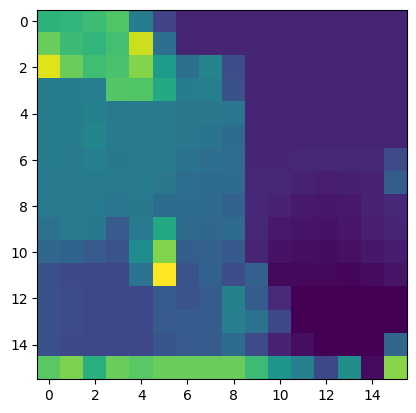

In [22]:
plt.imshow(simplification.represent_conical())

So the prototype works for small pictures. But the kernel could die in some cases. What can be a reason?

The problem should be somewhere in `cplane.get_map_disk_to_unit`, `cmap.get_map_boundary_to_unit_circle`. 

# Experiment

## Get Depth Posets from an Image

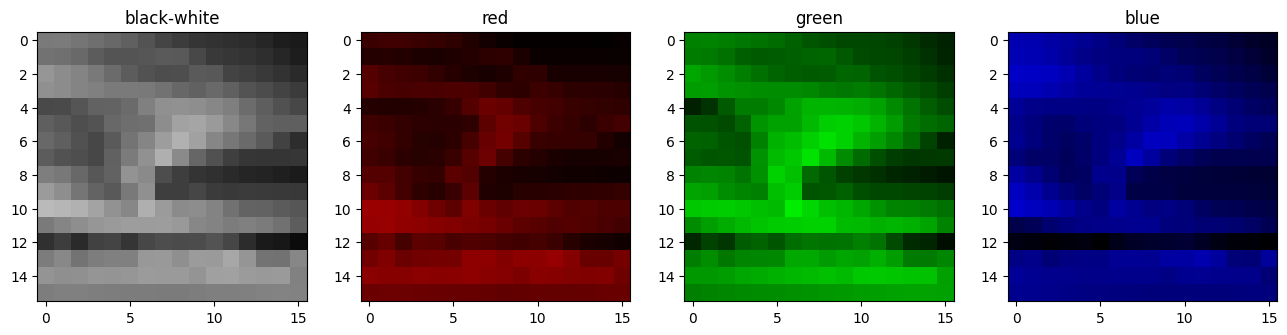

In [23]:
cases = {
    'black-white': image.mean(axis=2),
    'red': image[:, :, 0], 
    'green': image[:, :, 1], 
    'blue': image[:, :, 2], 
}

case_representations = {
    'black-white': lambda img: np.transpose([1*img, 1*img, 1*img], (1, 2, 0)), 
    'red': lambda img: np.transpose([1*img, 0*img, 0*img], (1, 2, 0)), 
    'green': lambda img: np.transpose([0*img, 1*img, 0*img], (1, 2, 0)), 
    'blue': lambda img: np.transpose([0*img, 0*img, 1*img], (1, 2, 0)), 
}

fig, axs = plt.subplots(1, len(cases), figsize=(4*len(cases), 4.5))

for i, key in enumerate(cases.keys()):
    axs[i].set_title(key)
    img = case_representations[key](cases[key])
    axs[i].imshow(img)




In [24]:
simplifyers = {key: DepthSimplifyer(img) for key, img in tqdm(cases.items(), total=len(cases))}

100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


In [25]:
dps = {key: simplifyer.depth_poset for key, simplifyer in simplifyers.items()}

scores = [poset_scores.number_of_nodes, 
          poset_scores.number_of_relations, 
          poset_scores.number_of_components,
          poset_scores.height, 
          poset_scores.width,
          ]

case_scores = pd.DataFrame({key: {score.__name__: score(dp) for score in scores} for key, dp in dps.items()})
case_scores

,black-white,red,green,blue
number_of_nodes,255,255,255,255
number_of_relations,136,115,144,113
number_of_components,121,143,114,142
height,3,3,4,3
width,238,233,238,243


## Iteratively Canceling Minimal Nodes

In [26]:
max_height = case_scores.loc['height'].max()

max_height

np.int64(4)

In [27]:
df_simplifications = pd.DataFrame([{key: simplifyer.get_simplified_by_canceling_minimals(n_iters=i) for key, simplifyer in simplifyers.items()} for i in range(max_height)])

df_simplifications

,black-white,red,green,blue
0,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...
1,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...
2,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...
3,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...,<__main__.SimplifiedByCancelations object at 0...


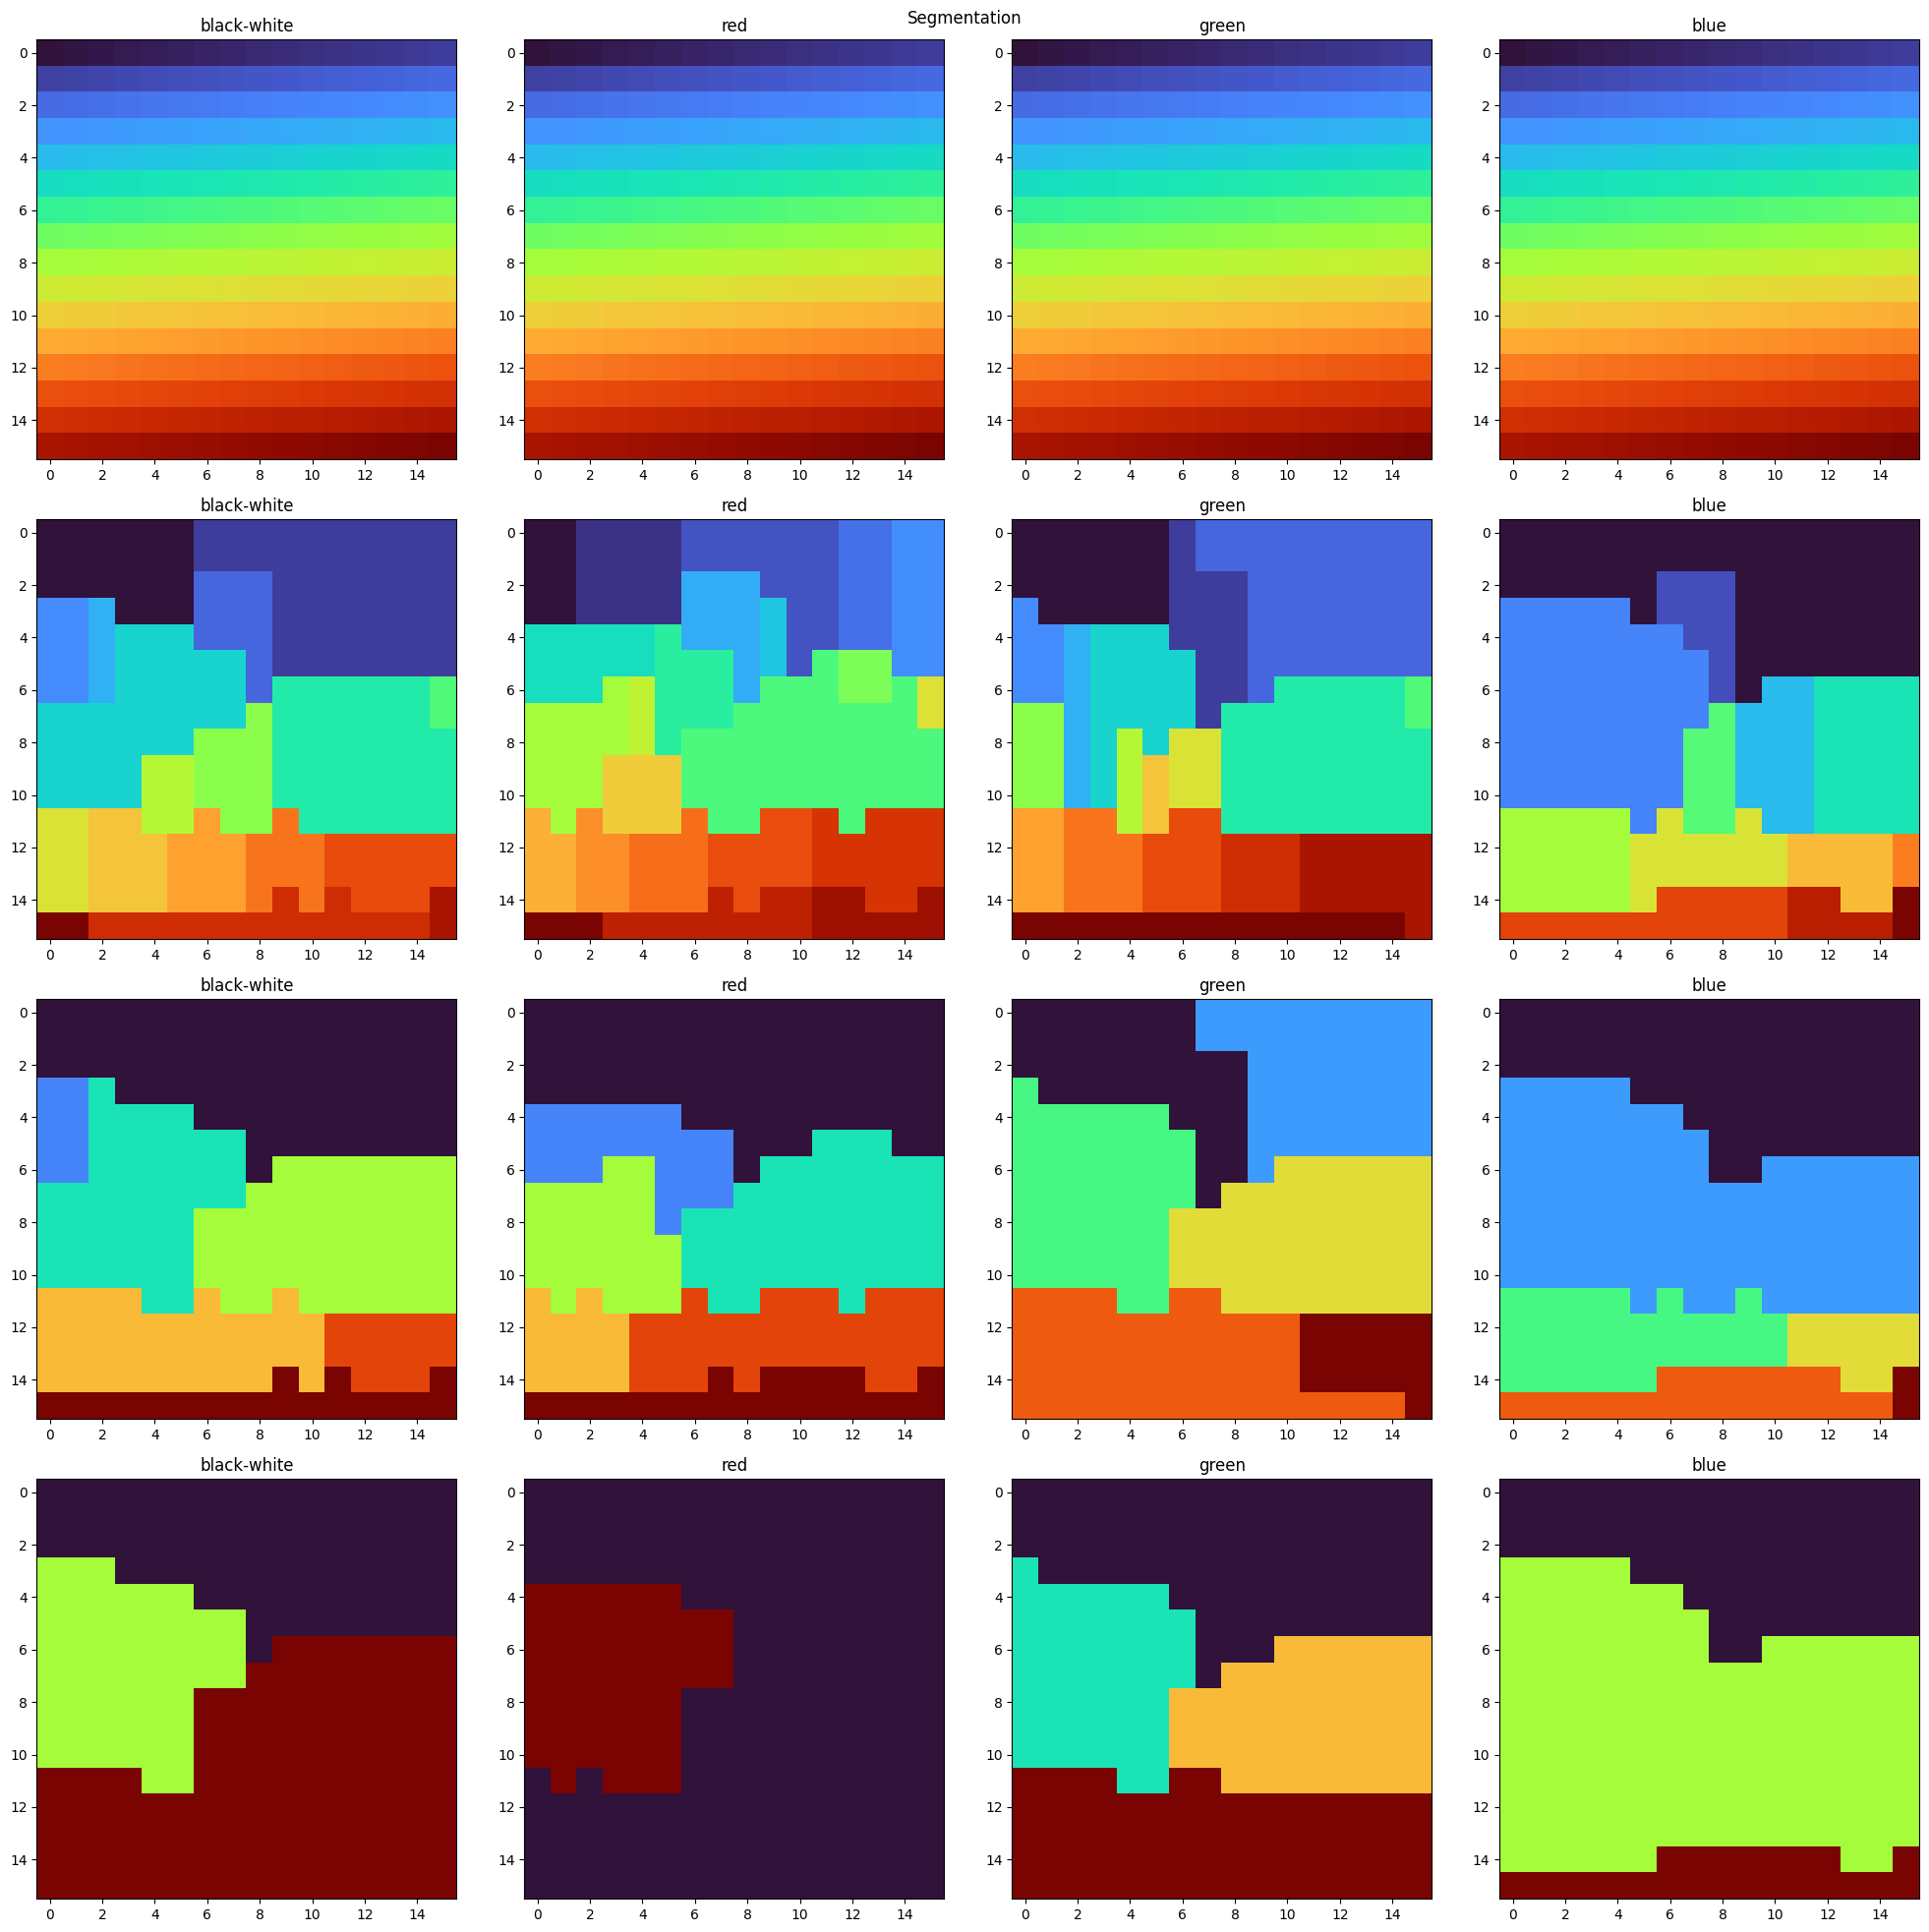

In [28]:
fig, axs = plt.subplots(df_simplifications.shape[0], df_simplifications.shape[1], squeeze=True)
fig.set_figheight(5*df_simplifications.shape[0])
fig.set_figwidth(5*df_simplifications.shape[1])

fig.suptitle('Segmentation')
for i_row, (i_col, key) in itertools.product(range(len(df_simplifications)), enumerate(df_simplifications.columns)):
    axs[i_row, i_col].set_title(key)
    img = df_simplifications.iloc[i_row, i_col].get_segmentation()
    
    axs[i_row, i_col].imshow(img, cmap='turbo')

plt.tight_layout()
plt.show()

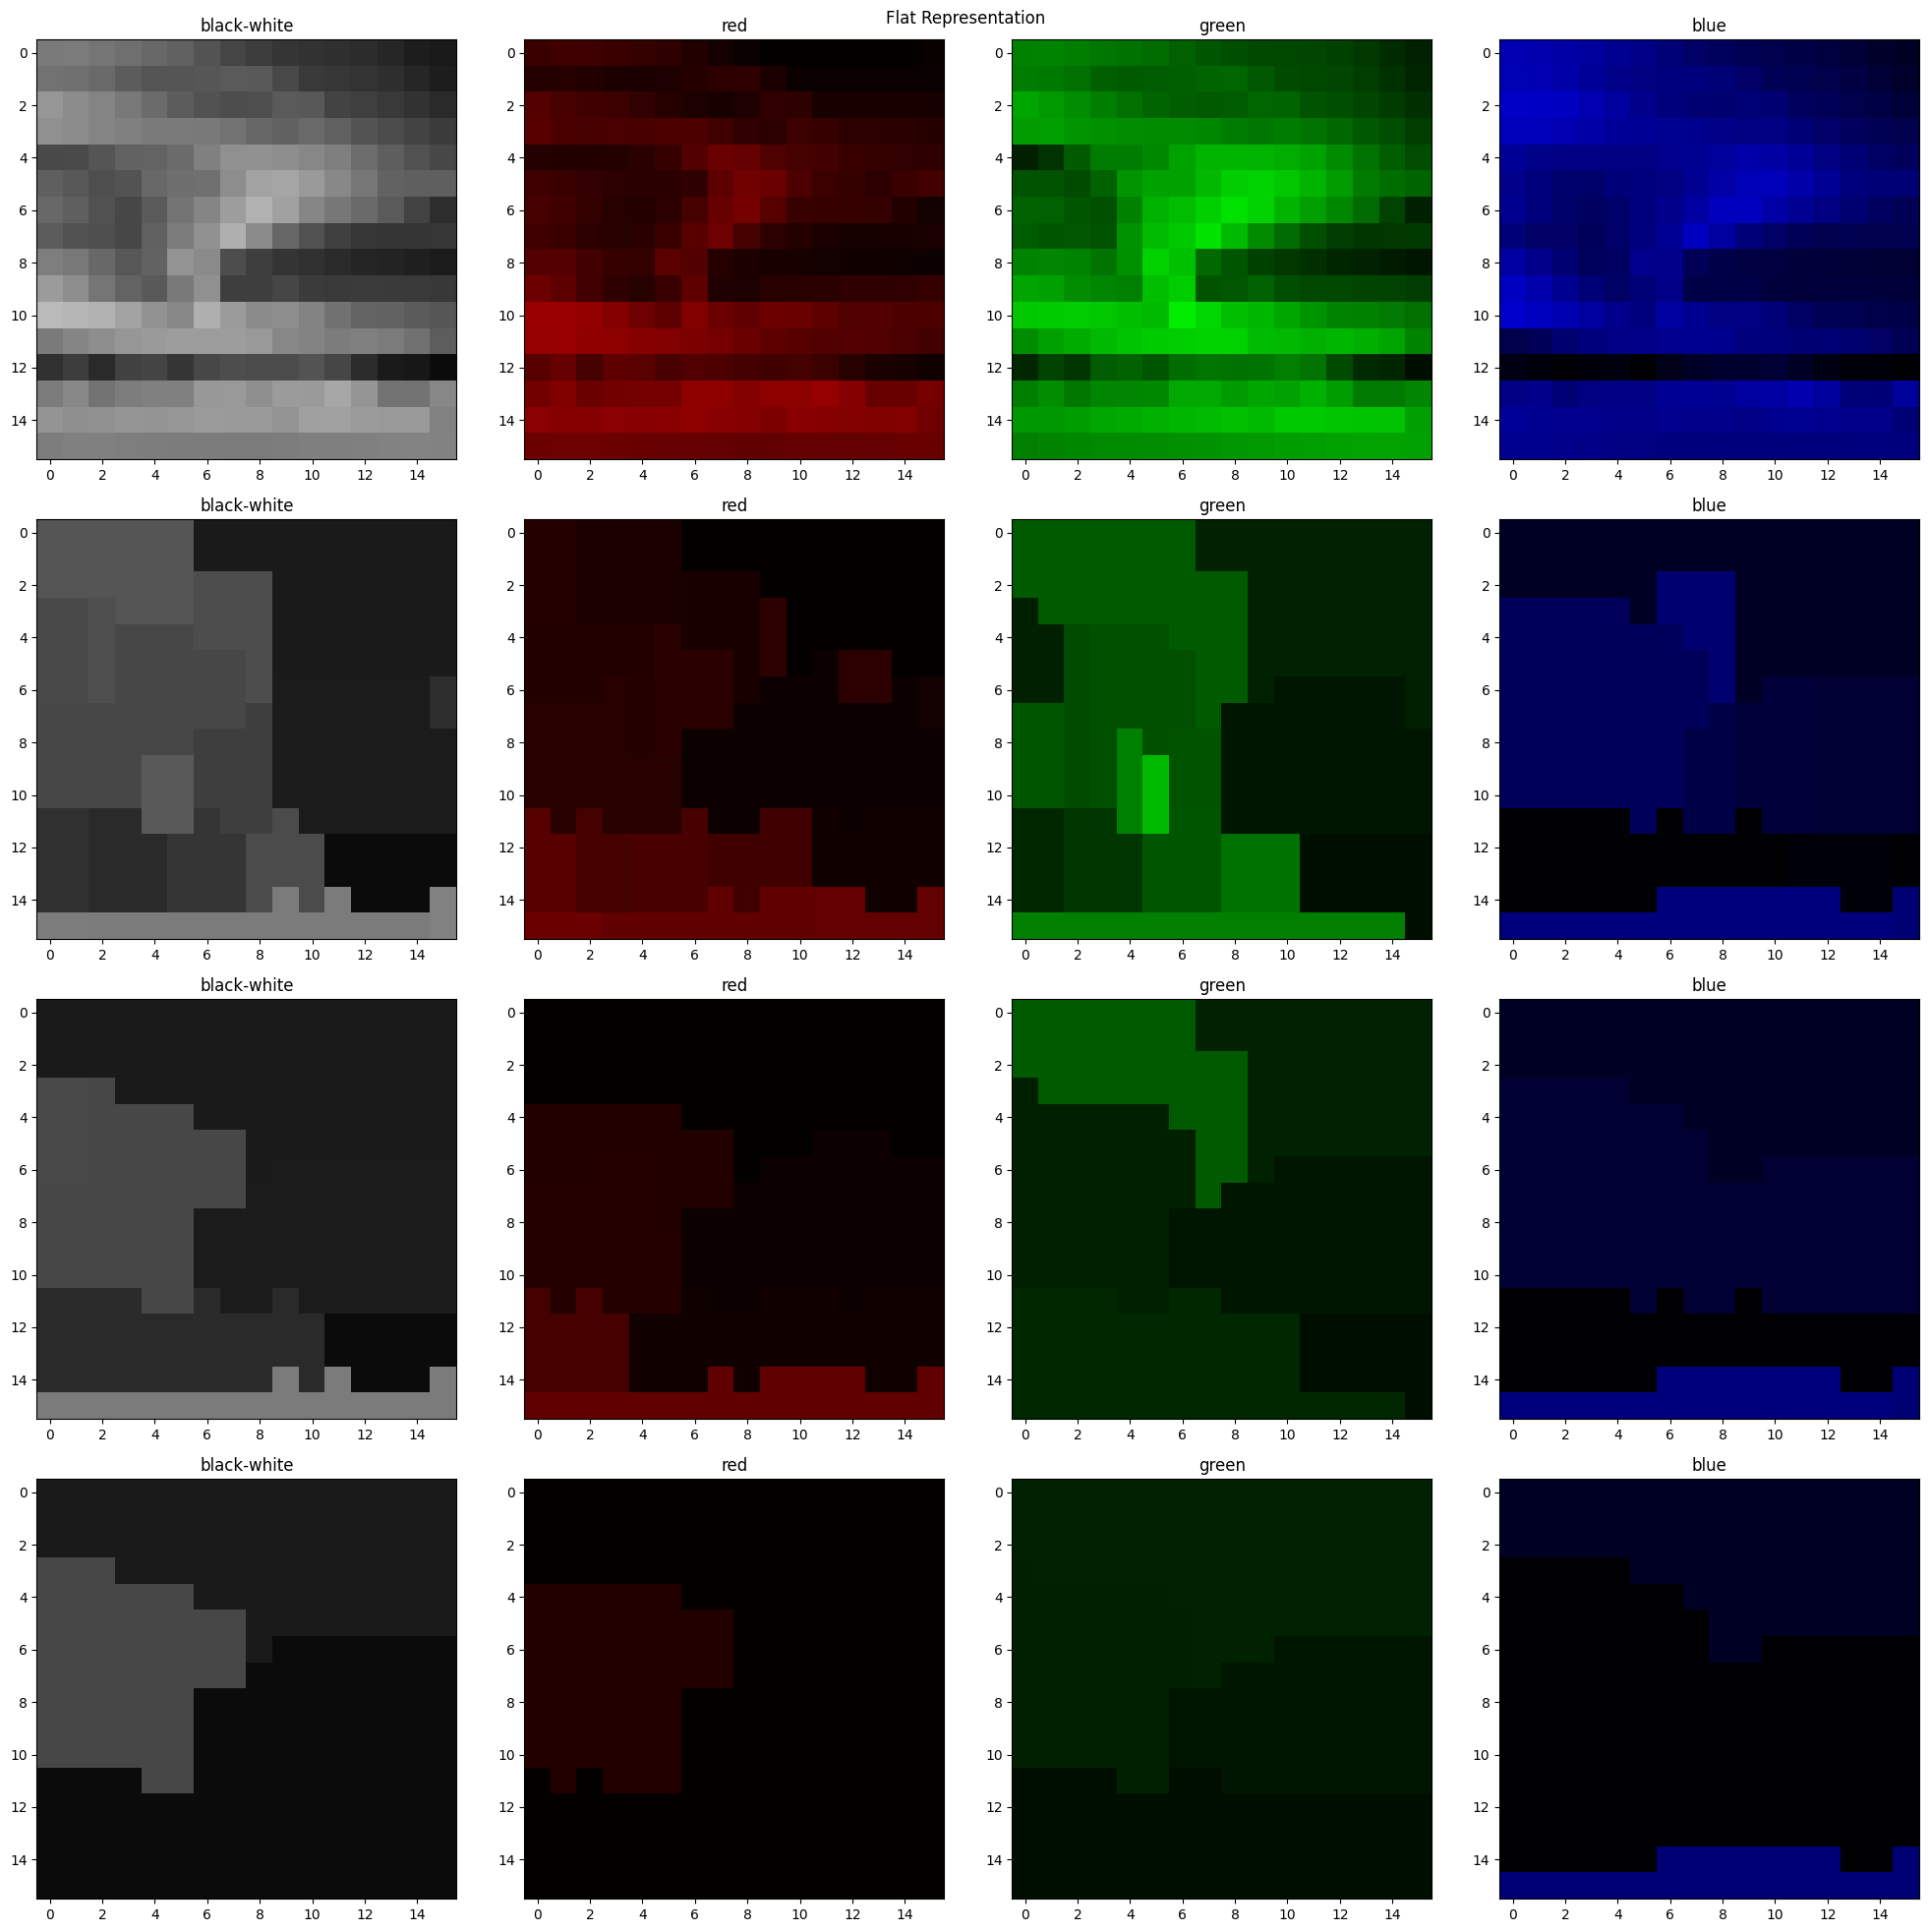

In [29]:
fig, axs = plt.subplots(df_simplifications.shape[0], df_simplifications.shape[1], squeeze=True)
fig.set_figheight(5*df_simplifications.shape[0])
fig.set_figwidth(5*df_simplifications.shape[1])

fig.suptitle('Flat Representation')
for i_row, (i_col, key) in itertools.product(range(len(df_simplifications)), enumerate(df_simplifications.columns)):
    axs[i_row, i_col].set_title(key)
    img = df_simplifications.iloc[i_row, i_col].represent_flat()
    img = case_representations[key](img)
    axs[i_row, i_col].imshow(img, cmap='turbo')

plt.tight_layout()
plt.show()

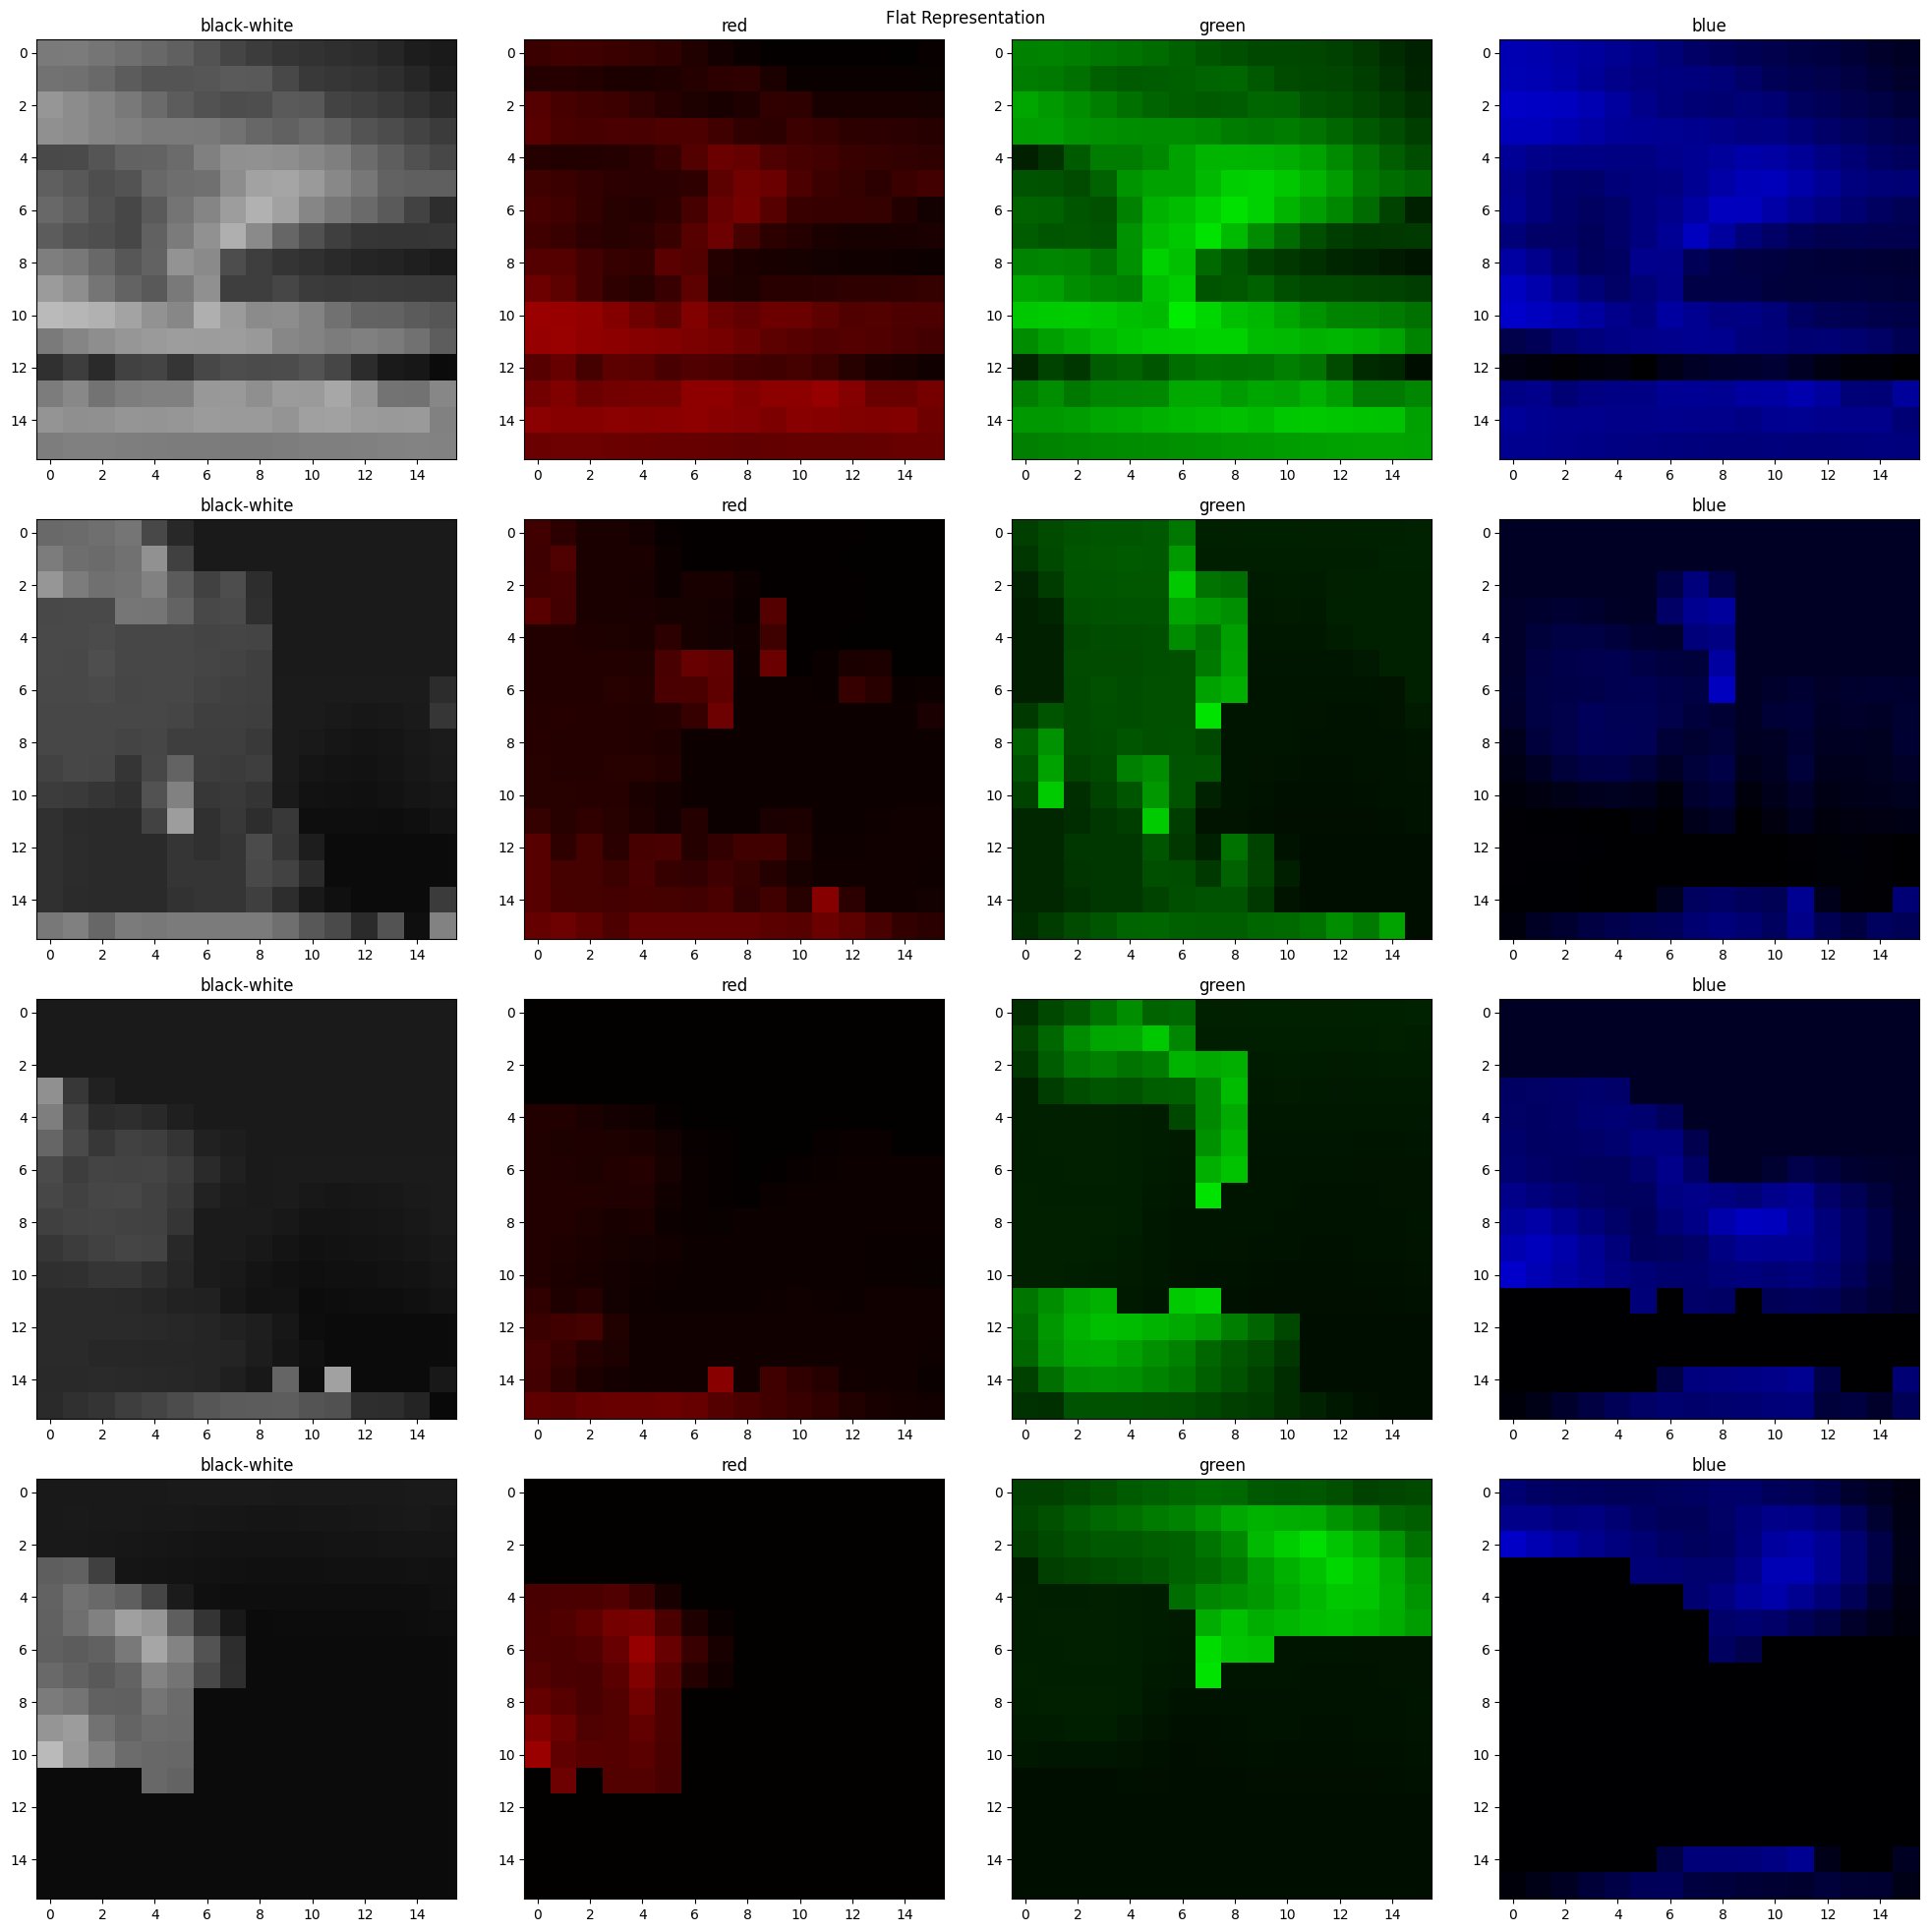

In [30]:
fig, axs = plt.subplots(df_simplifications.shape[0], df_simplifications.shape[1], squeeze=True)
fig.set_figheight(5*df_simplifications.shape[0])
fig.set_figwidth(5*df_simplifications.shape[1])

fig.suptitle('Flat Representation')
for i_row, (i_col, key) in itertools.product(range(len(df_simplifications)), enumerate(df_simplifications.columns)):
    axs[i_row, i_col].set_title(key)
    img = df_simplifications.iloc[i_row, i_col].represent_conical()
    img = case_representations[key](img)
    axs[i_row, i_col].imshow(img, cmap='turbo')

plt.tight_layout()
plt.show()

## Cancel by Lifelength

In [41]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

  0%|          | 0/1 [00:00<?, ?it/s]

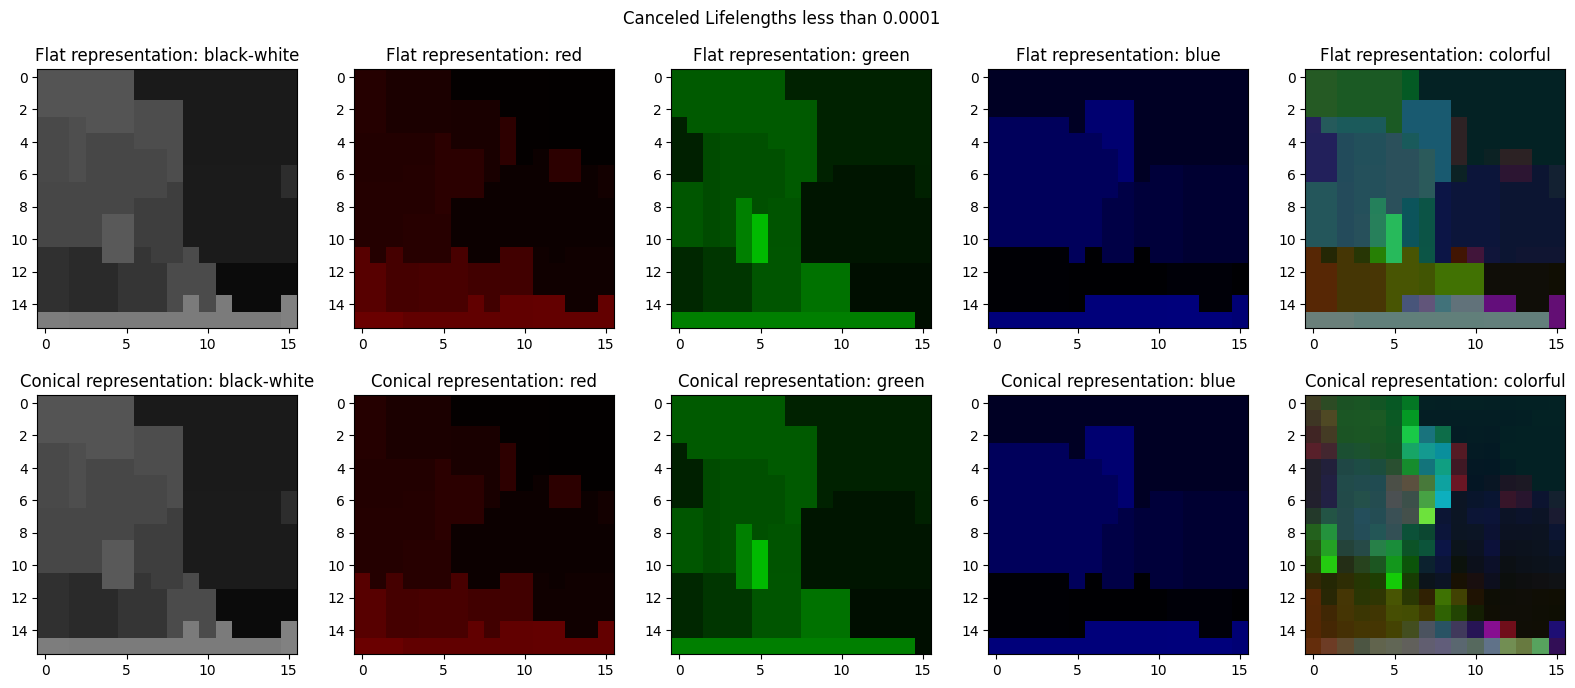

  0%|          | 0/1 [00:02<?, ?it/s]


In [61]:
lifelengths = np.concatenate([np.linspace(0, 0.1, 101), np.linspace(0.1, 0.5, 51), np.linspace(0.5, 1.0, 26)])

lifelengths = [0.00005]

images = []
for liefelength in tqdm(lifelengths):
    fig, axs = plt.subplots(2, 5, figsize=(16, 7))
    fig.suptitle(f'Canceled Lifelengths less than {liefelength:.4f}')

    simplifications = {key: simplifyer.get_simplified_by_canceling_short_lifes(liefelength) for key, simplifyer in simplifyers.items()} 
    imgs_flat = {key: simplification.represent_flat() for key, simplification in simplifications.items()}
    imgs_conical = {key: simplification.represent_conical() for key, simplification in simplifications.items()}

    for i, key in enumerate(simplifications.keys()):
        axs[0, i].set_title(f'Flat representation: {key}')
        axs[0, i].imshow(case_representations[key](imgs_flat[key]))
        axs[1, i].set_title(f'Conical representation: {key}')
        axs[1, i].imshow(case_representations[key](imgs_flat[key]))

    colorful_flat = np.transpose([imgs_flat[key] for key in ['red', 'green', 'blue']], (1, 2, 0))
    axs[0, 4].set_title(f'Flat representation: colorful')
    axs[0, 4].imshow(colorful_flat)

    colorful_conical = np.transpose([imgs_conical[key] for key in ['red', 'green', 'blue']], (1, 2, 0))
    axs[1, 4].set_title(f'Conical representation: colorful')
    axs[1, 4].imshow(colorful_conical)

    plt.tight_layout()
    plt.show()
    break


# Reduction algorithms for sparse border matrices